In [1]:
import os, random,cv2
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from pathlib import Path
from numpy import linalg as LA
from numpy.linalg import inv

## PIE data pre-processing

In [2]:
folders = random.sample(range(1, 68), 25)
training_set_list = []
test_set_list = []
training_label_list = []
test_label_list = []

for folder in folders:
    sub_train_img_list = []
    sub_train_label_list = []
    sub_test_img_list = []
    sub_test_label_list = []
    
    # select random folder subject
    folder_path = os.getcwd()+"/PIE/%s"%folder
    jpg_files = [f for f in os.listdir(folder_path) if f.endswith('.jpg')]
    sub_training_img_file =random.sample(jpg_files, 119)
    sub_test_img_file = [f for f in jpg_files if f not in sub_training_img_file]
    
    for single_file in sub_training_img_file:
        single_img = cv2.imread(folder_path+'/'+single_file , cv2.IMREAD_GRAYSCALE)
        # flatten the pixel value from (32,32) to (1,1024)
        single_img = single_img.reshape(1,1024)
        #sub_train_img_list.append(single_img)
        #sub_train_label_list.append(folder)
        training_set_list.append(single_img)
        training_label_list.append(folder)
    
    for single_file in sub_test_img_file:
        single_img = cv2.imread(folder_path+'/'+single_file, cv2.IMREAD_GRAYSCALE)
        single_img = single_img.reshape(1,1024)
        print(single_img)
        print('')
        #sub_test_img_list.append(single_img)
        #sub_test_label_list.append(folder)        
        test_set_list.append(single_img)
        test_label_list.append(folder)

[[173 155 157 ...  37  36  35]]

[[90 85 92 ... 74 67 60]]

[[85 95 93 ... 92 87 80]]

[[46 53 58 ... 13 10  2]]

[[ 69  89 124 ...  18  17  18]]

[[56 50 42 ... 65 63 63]]

[[ 82  77 139 ...  21  20  22]]

[[63 47 50 ... 41 29 17]]

[[58 62 70 ... 14  6  9]]

[[60 57 65 ...  8 10 11]]

[[54 64 68 ... 14  4  8]]

[[71 72 92 ...  7 13 15]]

[[124 132 148 ...   8   0  16]]

[[64 73 75 ...  5  6 10]]

[[126 169 154 ...   9  14   6]]

[[147 150 164 ...   0   1   8]]

[[64 66 77 ...  8 18  0]]

[[67 74 72 ... 44 40 32]]

[[136 169 173 ...   0   9  14]]

[[ 80  74  75 ... 126 158 162]]

[[154 133  78 ...  49  46  43]]

[[176 167 180 ...  58  68  73]]

[[157 161 154 ...  52  56  55]]

[[166 133 149 ...  45  51  55]]

[[182 144 146 ...  43  50  56]]

[[124 117 122 ...  52  69  86]]

[[161 158 171 ...  54  59  57]]

[[13 17 20 ...  8 14  0]]

[[ 85  79 106 ...  12   0  13]]

[[112 113 119 ...   1   1   8]]

[[ 99 110 120 ...   5   4   2]]

[[169 142 168 ...   6   5   4]]

[[26 24 39 ... 64 62 5

[[61 55 50 ...  8  6  4]]

[[ 8  1 16 ...  4 16 40]]

[[10  7  5 ... 50 43 51]]

[[23 10 32 ... 47 43 47]]

[[ 9 16 24 ... 27 27 25]]

[[18 17 40 ... 31 29 26]]

[[17 10  7 ... 82 75 79]]

[[17 15 22 ... 43 39 33]]

[[  5   9   9 ... 230  79  31]]

[[ 13  49  45 ... 232 210 225]]

[[ 18  41  44 ... 241 235 229]]

[[19 14 10 ... 77 78 80]]

[[ 2 84 78 ... 27 27 17]]

[[  1   7  11 ... 228 254 223]]

[[ 11  63  61 ... 171 131 167]]

[[  4  30  31 ... 142 117  83]]

[[ 3  5  7 ... 21 35 63]]

[[11  8  5 ... 36 41 55]]

[[ 6 22 45 ... 14  0 13]]

[[11  4  2 ... 77 74 79]]

[[40 54 61 ... 15 30 25]]

[[43 67 63 ... 18 18 23]]

[[22 24 27 ...  8  7  5]]

[[ 17  19  22 ...  99 112 106]]

[[39 30 46 ... 22 17 29]]

[[32 37 43 ... 16  0 13]]

[[26 40 53 ... 13  2 11]]

[[35 30 24 ... 56 41 81]]

[[55 82 82 ... 14  5  4]]

[[62 89 94 ... 12  0 13]]

[[50 65 79 ...  9  5 12]]

[[36 49 55 ... 18  6  2]]

[[40 83 69 ...  5 10  1]]

[[48 68 61 ...  7 15  5]]

[[20 23 26 ...  6 15  3]]

[[72 80 62 ..

[[26 41 60 ... 76 79 83]]

[[155 165 162 ...   5   2   3]]

[[188 185 188 ...   2   3   8]]

[[ 92 107 115 ...   6   4   3]]

[[ 25  21  20 ... 156  60  31]]

[[43 39 79 ... 24 21 17]]

[[106 131 142 ...  55  56  57]]

[[ 81  92 172 ...  20  16   9]]

[[46 30 57 ... 24 16  6]]

[[  9  15  18 ... 229 222 230]]

[[ 13  16  20 ... 196 166 134]]

[[ 17  26  37 ... 217 187 148]]

[[ 14  17  18 ... 192 175 130]]

[[ 18  70 116 ...  33  34  19]]

[[  6  11  17 ... 192  93  36]]

[[  6  12  19 ... 153  82  48]]

[[ 18  48  79 ... 145  47  12]]

[[58 27 23 ... 67 75 83]]

[[23 50 95 ... 14 20 29]]

[[ 23  33  60 ... 123  55  69]]

[[ 51  30  16 ... 107 124 142]]

[[49 29 15 ... 67 78 92]]

[[81 50 17 ... 70 76 88]]

[[24 23 15 ... 19 19 19]]

[[32 33 11 ... 25 24 23]]

[[27 24 59 ... 39 33 37]]

[[72 55 57 ...  8  9 12]]

[[65 58 61 ... 12  6  7]]

[[66 63 62 ... 13  7  7]]

[[117 131 136 ...  21   0  12]]

[[170 163 194 ...   6  17   4]]

[[166 180 209 ...   7  19   8]]

[[106 117 127 ...  10 

[[14 20 24 ...  3  7 10]]

[[123 116 134 ...   6   5   5]]

[[170 179 179 ...   7   6   5]]

[[ 7 12 15 ...  5  2  5]]

[[102 106 101 ...   4   4   5]]

[[ 9 12 17 ... 12 10 27]]

[[ 8 13 18 ... 20 14 24]]

[[ 7 11 14 ... 14 28 13]]

[[ 11   7  15 ...  74 133 224]]

[[ 26  71 105 ...  26  30  32]]

[[28 64 94 ...  9  9  9]]

[[ 91 106 113 ...   4  19  10]]

[[ 95 102 104 ...   9  11   8]]

[[141 162 166 ...   9   6   8]]

[[ 8 11 14 ... 46 49 38]]

[[10 10 12 ... 44 54 43]]

[[31 51 64 ... 85 94 86]]

[[ 60 100 114 ...  10  31  16]]

[[ 45  96 120 ...  66  72  70]]

[[ 53  92 111 ...  43  44  42]]

[[130 140 154 ...  56  53  49]]

[[ 69  72  77 ... 136 140 132]]

[[ 91  85  82 ... 133 131 119]]

[[178 166 144 ... 118 101  88]]

[[191 172 160 ...  94  74  51]]

[[229 204 162 ...  45  35  28]]

[[224 232 193 ...  24  23  22]]

[[105 111 106 ...  23  23  23]]

[[100 100  92 ... 101  84  70]]

[[116 107 101 ...  60  45  33]]

[[123 134 106 ...  26  26  30]]

[[130 127 106 ...  20  22  23]]

[[55 54 53 ... 18  0  7]]

[[ 66  33  19 ... 154 147 158]]

[[32 19 13 ... 70 65 57]]

[[58 39 31 ... 77 68 62]]

[[64 43 33 ... 85 76 67]]

[[50 49 36 ... 53 42 25]]

[[42 29 29 ... 21 19 19]]

[[38 45 50 ... 20 20 20]]

[[58 39 28 ... 88 81 76]]

[[58 51 44 ... 82 73 51]]

[[39 33 45 ... 20 30 13]]

[[67 71 76 ... 13  7 10]]

[[116 132 130 ...  17   7  12]]

[[49 52 55 ... 53 58 53]]

[[137 140 165 ...  13   4  13]]

[[178 174 188 ...  10   0  10]]

[[ 74  81  89 ... 114 115 166]]

[[108 104 120 ...  84  83  87]]

[[114  79  32 ...  46  46  46]]

[[102 115 125 ...  75  88 106]]

[[117 120 136 ...  57  75 102]]

[[18 20 22 ... 11  3  8]]

[[13 17 23 ...  0 16  4]]

[[73 68 69 ... 58 55 48]]

[[43 45 49 ...  8  0  9]]

[[100  90 103 ...   2  14   0]]

[[10 13 16 ...  4  3  6]]

[[31 38 47 ...  0  7  0]]

[[111 114 122 ...   2   6   6]]

[[51 50 51 ... 51 71 93]]

[[54 70 90 ... 20 15 15]]

[[40 60 83 ... 36 26 26]]

[[47 65 84 ... 16 15 14]]

[[ 50 102 121 ...  15  15  15]]

[[14 13 16

In [3]:
type(test_set_list[2])
type(test_label_list[2])

int

## SELF photo pre-processing

In [4]:
# get gray-scale and reshape the images
self_path = os.getcwd()+'/self'
self_img_list = []
for sub_self_img in os.listdir(self_path):
    if sub_self_img.startswith('self'):
        color_image = cv2.imread(self_path+'/'+sub_self_img)

        # convert colorful image to gray-scale image
        gray_image = cv2.cvtColor(color_image, cv2.COLOR_BGR2GRAY)
        # resize image to 32*32 pixels 
        resized_image = cv2.resize(gray_image, (32, 32))
        resized_image = resized_image.reshape(1,1024)
        #print(resized_image.shape)
        self_img_list.append(resized_image)


## grouping self and PIE dataset to be total dataset

In [5]:
# split slef-images into train and test

# label self img as 100        
for single_self_img in self_img_list[:7]:
    training_set_list.append(single_self_img)
    training_label_list.append(100)
for single_self_img in self_img_list[7:]:
    test_set_list.append(single_img)
    test_label_list.append(100)

In [6]:
## add self img to total train and test set
#training_set_list.append(self_train_img_list)
#training_label_list.append(self_train_label_list)
#test_set_list.append(self_test_img_list)
#test_label_list.append(self_test_label_list)

In [7]:
## flatten 2-dim list into 1-dim list
#trainSet = []
#trainLabel = []
#testSet = []
#testLabel = []
#
#for sublist in training_set_list:
#    for element in sublist:
#        trainSet.append(element)
#
#for sublist in training_label_list:
#    for element in sublist:
#        trainLabel.append(element)
#        
#for sublist in test_set_list:
#    for element in sublist:
#        testSet.append(element)
#        
#for sublist in test_label_list:
#    for element in sublist:
#        testLabel.append(element)

## PCA

1. select 500 img randomly from training set

In [213]:
samples = np.random.default_rng(120).choice(np.arange(2982), 500, replace=False)
X_train = []
y_train = []
for i in samples:
    #print(i)
    X_train.append(training_set_list[i])
    y_train.append(training_label_list[i])
X_train = np.array(X_train) # numpy.ndarray, each element is numpy.ndarray
#y_train = np.array(y_train)
mean_X = np.mean(X_train, axis = 0)
centered_X = X_train - mean_X # numpy.ndarray

In [214]:
mean_X.shape

(1, 1024)

In [216]:
centered_X = centered_X.reshape(500,1024)
centered_X = centered_X.T
U, D, VT = np.linalg.svd(centered_X , full_matrices=False)
U_tt = U@U.T
D_diag = np.diag(D)
sorted_indices = np.argsort(D)
print(sorted_indices[-1], sorted_indices[-2] , sorted_indices[-3])# D[0],D[1] are the two largest eigenvalue, relatively as columns in U 

U_2d = U[:,:2]
U_3d = U[:,:3]

mean_X_2 = mean_X[:,:2]
mean_X_2 = mean_X_2.reshape(2,1)

mean_X_3 = mean_X[:,:3]
mean_X_3 = mean_X_3.reshape(3,1)

X_restructure_2d =  U_2d.T @ centered_X + mean_X_2
X_restructure_2d = X_restructure_2d.T

X_restructure_3d =  U_3d.T @ centered_X + mean_X_3
X_restructure_3d = X_restructure_3d.T

0 1 2


In [223]:
X_restructure_2d.shape

(500, 2)

## 2D PCA plot

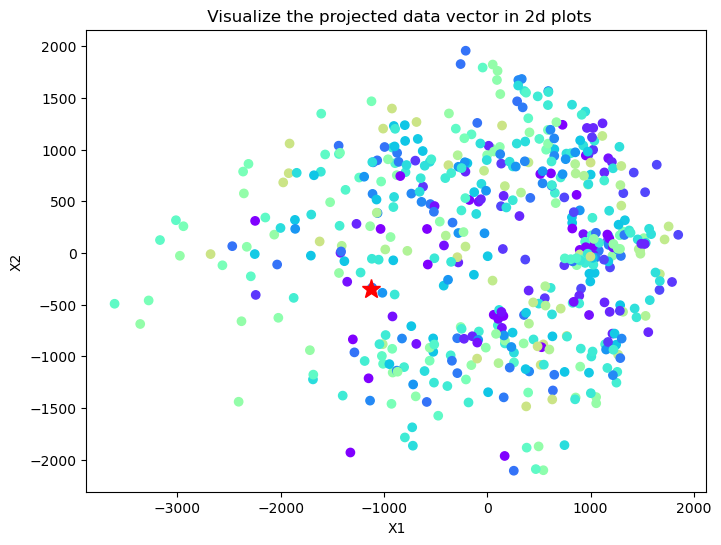

In [224]:
fig = plt.figure(figsize = (8,6))
ax = fig.add_subplot(111)
scatter = ax.scatter(X_restructure_2d[:,0], X_restructure_2d[:,1], c=y_train ,cmap = 'rainbow')
indices = [i for i, x in enumerate(y_train) if x == 100] # the position of self photo
plt.plot(X_restructure_2d[indices,0], X_restructure_2d[indices,1],  'r*', markersize=14)
ax.set_xlabel("X1")
ax.set_ylabel("X2")
ax.set_title(' Visualize the projected data vector in 2d plots')
plt.show()

## 3D PCA plot

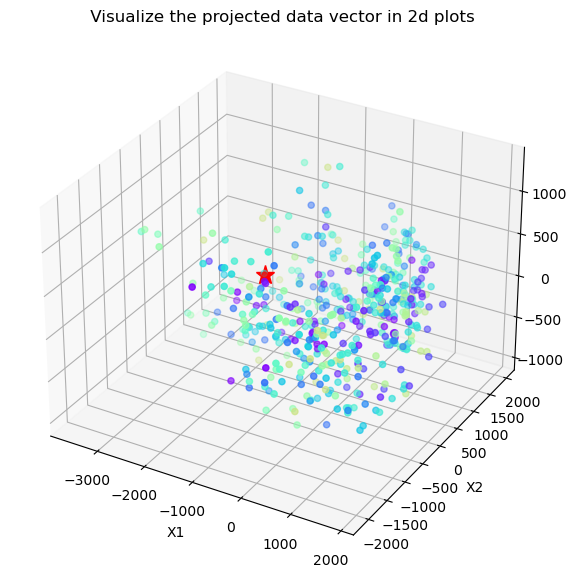

In [225]:

fig = plt.figure(figsize = (7,7))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_restructure_3d[:,0], X_restructure_3d[:,1],X_restructure_3d[:,2], c=y_train ,cmap = 'rainbow')
indices = [i for i, x in enumerate(y_train) if x == 100] # the position of self photo
plt.plot(X_restructure_3d[indices,0], X_restructure_3d[indices,1], X_restructure_3d[indices,2], 'r*', markersize=14)
ax.set_xlabel("X1")
ax.set_ylabel("X2")
ax.set_title(' Visualize the projected data vector in 2d plots')
plt.show()

In [163]:
y_train

[8,
 1,
 30,
 60,
 6,
 17,
 60,
 39,
 34,
 54,
 19,
 35,
 54,
 30,
 60,
 42,
 53,
 29,
 44,
 38,
 65,
 3,
 38,
 60,
 10,
 34,
 16,
 44,
 44,
 37,
 29,
 29,
 60,
 54,
 17,
 53,
 49,
 16,
 39,
 38,
 1,
 53,
 37,
 6,
 30,
 38,
 38,
 29,
 3,
 1,
 49,
 55,
 39,
 44,
 34,
 3,
 3,
 1,
 63,
 39,
 3,
 6,
 49,
 37,
 42,
 35,
 19,
 6,
 10,
 53,
 38,
 65,
 29,
 39,
 19,
 29,
 65,
 16,
 1,
 44,
 54,
 29,
 21,
 44,
 29,
 60,
 49,
 21,
 53,
 49,
 16,
 6,
 19,
 65,
 19,
 29,
 16,
 19,
 34,
 3,
 65,
 42,
 60,
 3,
 29,
 8,
 53,
 65,
 10,
 49,
 35,
 53,
 42,
 44,
 37,
 1,
 39,
 49,
 55,
 35,
 16,
 39,
 49,
 39,
 17,
 34,
 8,
 21,
 55,
 49,
 16,
 35,
 3,
 54,
 54,
 53,
 29,
 6,
 34,
 1,
 55,
 8,
 63,
 29,
 19,
 19,
 54,
 60,
 63,
 17,
 44,
 44,
 37,
 10,
 54,
 35,
 44,
 21,
 8,
 17,
 8,
 30,
 54,
 35,
 21,
 6,
 29,
 44,
 53,
 63,
 16,
 65,
 37,
 60,
 34,
 21,
 1,
 10,
 21,
 42,
 6,
 53,
 8,
 44,
 29,
 44,
 55,
 60,
 55,
 44,
 10,
 6,
 55,
 63,
 21,
 29,
 54,
 19,
 16,
 49,
 44,
 49,
 37,
 65,
 38,
 42,
 2

## reduce dim to 40, 80 ,200 respectively

In [230]:
## dim = 40
U_40d = U[:,:40]
mean_X_40 = mean_X[:,:40]
mean_X_40 = mean_X_40.reshape(40,1)
X_restructure_40d =  U_40d.T @ centered_X + mean_X_40
X_restructure_40d = X_restructure_40d.T

# dim = 80
U_80d = U[:,:80]
mean_X_80 = mean_X[:,:80]
mean_X_80 = mean_X_80.reshape(80,1)
X_restructure_80d =  U_80d.T @ centered_X + mean_X_80
X_restructure_80d = X_restructure_80d.T

# dim = 200
U_200d = U[:,:200]
mean_X_200 = mean_X[:,:200]
mean_X_200 = mean_X_200.reshape(200,1)
X_restructure_200d =  U_200d.T @ centered_X + mean_X_200
X_restructure_200d = X_restructure_200d.T

# verification
X_restructure_200d.shape,X_restructure_80d.shape,X_restructure_40d.shape

((500, 200), (500, 80), (500, 40))

(500, 200)

## PCA with Lib

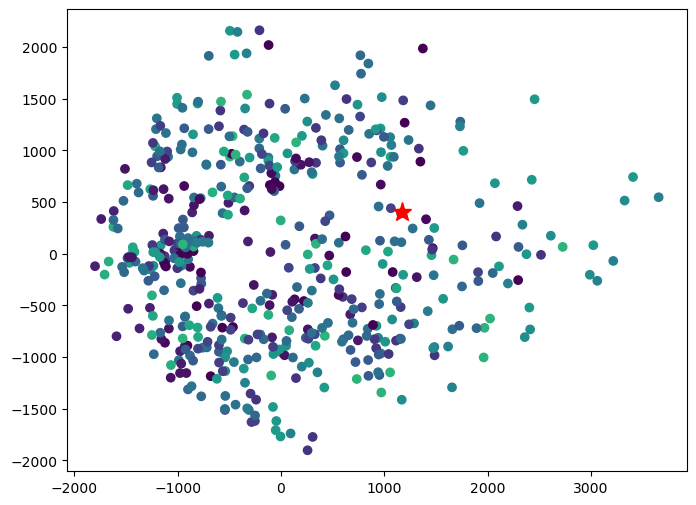

In [235]:
from sklearn.decomposition import PCA
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
# Sample 500 data points
X_train_re = X_train.reshape(500,1024)
# 2D Plot
pca = PCA(n_components=2)
pca.fit(X_train_re)
X_transformed = pca.transform(X_train_re)
fig = plt.figure(figsize = (8,6))
ax = fig.add_subplot(111)
scatter = ax.scatter(X_transformed[:, 0], X_transformed[:, 1], c=y_train)
legend1 = ax.legend(*scatter.legend_elements(num=20), loc=(1.1, 0), title="classes", ncol=2)
indices = [i for i, x in enumerate(y_train) if x == 100] # the position of self photo
plt.plot(X_transformed[indices,0], X_transformed[indices,1],  'r*', markersize=14)
ax.add_artist(legend1)
plt.show()

## test

In [ ]:
S = U @ D_diag @ D_diag @ U.T
mean_X_matrix = np.tile(mean_X, (500, 1))
X_pca_0 = mean_X_matrix.T + U_tt[:,:2]@ U_tt[:,:2].T @centered_X # 1024* 500 each column means a single x value
np.linalg.eig(S)